In [15]:
import numpy as np
import pandas as pd
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import FunctionTransformer
from sklearn.metrics import classification_report
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import OneHotEncoder
import sklearn

# project helper
from prepare_data import load_clean_dataframe  # type: ignore

sklearn.set_config(enable_metadata_routing=True)


# ------------------------------------------------------------------
# 1. LOAD DATA  –  same starting point as hybrid_text_model_main.ipynb
# ------------------------------------------------------------------
df = load_clean_dataframe(labelled_only=True)

X = df.drop(columns=["bid"])
y = df["bid"]

df["title_len"] = df["title"].str.len()

y  = df["bid"]                # the target column
X  = df[["title",                       # text
         "title_len", # engineered numeric features you already had
         "ca", "procedure"]]            # other categorical / numeric cols

# ------------------------------------------------------------------
# 2. DEFINE PREPROCESSING FOR EACH COLUMN TYPE
# ------------------------------------------------------------------
text_pipeline = Pipeline([
    ("tfidf", TfidfVectorizer(stop_words="english",
                              ngram_range=(1, 2),      # unigrams + bigrams
                              max_features=3000)),     # cap vocabulary
    ("svd", TruncatedSVD(n_components=120, random_state=42)),
]
)

numeric_cols = ["title_len"]
categorical_cols = ["ca", "procedure"]

preprocess = ColumnTransformer([
    ("text",  text_pipeline,     "title"),
    ("num",   "passthrough",     numeric_cols),
    ("cat",  OneHotEncoder(handle_unknown="ignore"), categorical_cols),
],
remainder="drop"
)

# ------------------------------------------------------------------
# 3. BUILD THE FULL PIPELINE: PREP ↦ DECISION TREE
# ------------------------------------------------------------------
dtree = DecisionTreeClassifier(max_depth=15,
                               min_samples_leaf=5,
                               random_state=42)

model = Pipeline([
    ("preprocess", preprocess),
    ("tree",       dtree),
])

# ------------------------------------------------------------------
# 4. TRAIN / EVALUATE
# ------------------------------------------------------------------
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42)

model.fit(X_train, y_train)

print("\nCross-validated F1-score:",
      cross_val_score(model, X_train, y_train, cv=5, scoring="f1").mean())

y_pred = model.predict(X_test)
print("\nHold-out performance")
print(classification_report(y_test, y_pred, digits=3))

/mnt/c/Users/rober/GitHub/module_2/python/prepare_data.py:46: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df["ca"].fillna("", inplace=True)
/mnt/c/Users/rober/GitHub/module_2/python/prepare_data.py:47: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col]


Cross-validated F1-score: 0.26068042002581737

Hold-out performance
              precision    recall  f1-score   support

           0      0.952     0.967     0.959       391
           1      0.409     0.321     0.360        28

    accuracy                          0.924       419
   macro avg      0.681     0.644     0.660       419
weighted avg      0.916     0.924     0.919       419



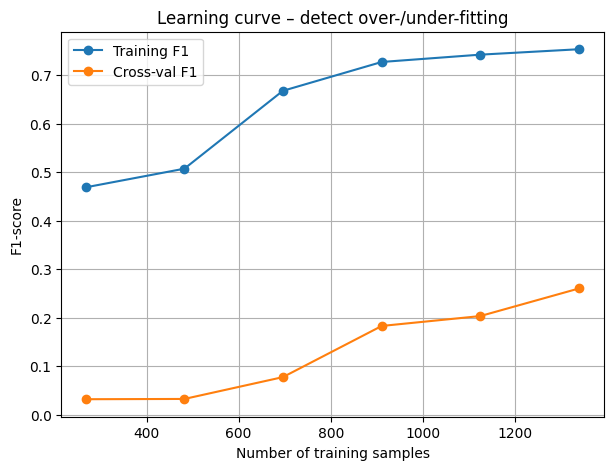

In [18]:
# --- Learning curve -------------------------------------------------
from sklearn.model_selection import learning_curve, StratifiedKFold
import matplotlib.pyplot as plt
import numpy as np

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

train_sizes, train_scores, val_scores = learning_curve(
    estimator=model,                # the Pipeline you just fitted
    X=X_train,
    y=y_train,
    train_sizes=np.linspace(0.2, 1.0, 6),  # 10 % … 100 % of the data
    cv=5,
    scoring="f1",
    n_jobs=-1,
)

train_mean = train_scores.mean(axis=1)
val_mean   = val_scores.mean(axis=1)

plt.figure(figsize=(7, 5))
plt.plot(train_sizes, train_mean, "o-", label="Training F1")
plt.plot(train_sizes, val_mean,   "o-", label="Cross-val F1")
plt.xlabel("Number of training samples")
plt.ylabel("F1-score")
plt.title("Learning curve – detect over-/under-fitting")
plt.grid(True)
plt.legend()
plt.show()